# 5. 챗GPT를 활용한 뉴스 긍부정 기반 전략

## (1) OpenAI python library 설치
- 챗GPT를 포함한 OpenAI의 API 접근 및 사용을 위한 Python Library이다.
- 커뮤니티 및 관련 정보는 아래 사이트에서 확인 가능하다.
    - Homepage : https://pypi.org/project/openai/
    - Github : https://github.com/openai/openai-python

In [1]:
# ! pip install openai

- 매일경제 사이트를 통해 뉴스 제목 데이터 수집을 위한 Package requests, beautifulsoup4, seleinum, webdriver_manager 설치: 주어진 데이터 사용 시, 설치 미필요

In [2]:
# ! pip install requests
# ! pip install beautifulsoup4
# ! pip install selenium
# ! pip install webdriver_manager

## (2) 데이터 가져오기
- 매일경제 사이트를 통해 원하는 키워드의 뉴스 제목 수집. 제공된 데이터 사용 시, 수집 미진행
    - Homepage: https://www.mk.co.kr/     

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ActionChains

from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import datetime
import os

import numpy as np


In [4]:
# 삼성전자 주가 데이터

data_samsung = pd.read_csv(r'005930.KS.csv', index_col=0)
data_samsung.columns=['open','high', 'low', 'close_not_adjusted', 'close', 'volume']
data_samsung

,open,high,low,close_not_adjusted,close,volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.727783,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.858887,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.599365,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.100586,46880000
...,...,...,...,...,...,...
2024-06-26,80100.0,81400.0,79900.0,81300.0,81300.000000,17783242
2024-06-27,81300.0,81600.0,80500.0,81600.0,81600.000000,11739720
2024-06-28,81900.0,81900.0,80800.0,81500.0,81500.000000,9455929


In [5]:
# 삼성전자 관련 뉴스 데이터 

fname = './news_005630.csv'                                           # 뉴스 데이터 파일명

keyword ='삼성전자'                                                    # 검색 키워드
startdate = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d")      # 수집 시작 일자
enddate = startdate + datetime.timedelta(days=1)


In [6]:
if os.path.exists(fname):    
    # 데이터 파일이 있는 경우

    df_news = pd.read_csv(fname, index_col=0)
else:
    # 데이터 파일이 없는 경우, 수집 진행

    news = []

    serv = Service(ChromeDriverManager().install())
    chromeOptions = webdriver.ChromeOptions()
    chromeOptions.add_argument('--headless')
    chromeOptions.add_argument('--no-sandbox')
    chromeOptions.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(service=serv, options=chromeOptions)

    while enddate < datetime.datetime.strptime('2024-07-01', "%Y-%m-%d"): # 2024년 7월 1일까지 수집 진행
        startdate_str = datetime.datetime.strftime(startdate, "%Y-%m-%d")
        enddate_str = datetime.datetime.strftime(enddate, "%Y-%m-%d")
        url = f'https://www.mk.co.kr/search?word={keyword}&dateType=direct&startDate={startdate_str}&endDate={enddate_str}&searchField=title' # 매일경제 내 해당 키워드 및 일자 뉴스 검색
        driver.get(url)

        n_news = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[2]/main/section/div/div[2]/div/div/div[1]/section/header/div[1]/h2/span'))).text # 검색된 뉴스 개수
        if n_news != '':

            soup = bs(driver.page_source, 'html.parser')
            news_date = soup.find_all("div", {"class": "txt_area"})

            while len(news_date) < int(n_news):
                try :
                    button = driver.find_element(By.CSS_SELECTOR, f'#all_cnt > div > div.col.main_col > section > div > div > div > button')                        
                    actions = ActionChains(driver).move_to_element(button)
                    actions.perform()
                    button.click()
                except:
                    time.sleep(1)

                soup = bs(driver.page_source, 'html.parser')
                news_date = soup.find_all("div", {"class": "txt_area"})
            
            # 뉴스 날짜 및 제목 추출
            news.extend([[n.find("div", {"class": "info_group"}).find("p", {"class": "time_info"}).text, n.find("h3", {"class": "news_ttl"}).text] for n in news_date])
            

        startdate = startdate + datetime.timedelta(days=1)
        enddate = enddate + datetime.timedelta(days=1)
        
    driver.quit()

    df_news = pd.DataFrame(news, columns=['date', 'title'])
    df_news.to_csv(fname)

In [7]:
df_news

,date,title
0,2000.01.02 12:21,[전문가 추천 유망종목] 삼성전자
1,2000.01.03 15:41,굿모닝증권 삼성전자 등 투자유망 40선 선정
2,2000.01.03 13:31,"와이즈소프트, 삼성물산 유투존 전자상거래 구축"
3,2000.01.03 11:50,"삼성전자, 세계서 가장 빠른 288메가급 램버스D램 개발"
4,2000.01.04 18:54,[공시] 데이콤/현대미포조선/이수화학/삼성전자
...,...,...
26414,2024.06.30 20:06,"EU, 구글-삼성전자 겨냥 'AI 협력' 반독점 조사 검토"
26415,2024.06.30 15:40,"“부모님 관리, 스마트싱스로”…삼성전자 ‘패밀리 케어’ 서비스"
26416,2024.06.30 13:00,재용이형 대신 의선이형...취준생 선택은 삼성전자 아닌 현대차
26417,2024.07.01 22:14,삼성전자 노조 “요구 관철될 때까지 無임금·無노동 파업”


## (3) 챗GPT를 이용한 뉴스 감성분석 및 주가 상승 가능성 예측
- openai를 통해 챗gpt prompt에 뉴스 제목에 대한 n일 후 관련 종목의 주가 상승 확률을 예측한다.  
    - API 발급 site: https://platform.openai.com/api-keys
    - reference site: https://platform.openai.com/docs/api-reference/introduction

In [8]:
from openai import OpenAI


def get_scores(client, titles, days, company='Sansung Electronics', model="gpt-3.5-turbo"):
    """
    주어진 뉴스 제목 list titles에 대해 list days 일 후의 company 주가의 상승 가능성을 구하는 함수
    client를 통해 챗 gpt 질문을 수행. 이때 모델은 gpt-3.5-turbo 사용을 추천
    """
    
    question = f'For each news title, find the probabilities for each news that the stock price of {company} will rise after {days[0]}, {days[1]}, {days[2]}, and {days[3]} days, respectively, compared to the day of the news: \n'
    for idx, title in enumerate(titles, start=1):
        question += f'{idx}. {title} \n'

    question += 'Answer for each news title in a line and state only probabilities between 0 and 100 with spaces between probabilities.'

    results = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": question}],
        stream=False,
        seed=0,
        temperature=0,
    ) # 질문에 따른 결과가 동일하게 나오게 하기 위해 seed와 temparature 각각 0으로 지정
    answer = results.choices[0].message.content
    
    return answer

In [9]:
# 실험 기간 분리 시점

t1, t2, t3 = '2010', '2020', '2024'

In [10]:
days = [1, 5, 10, 20, ] # 예측하고자 하는 가격 상승 시점 기준
learning_size = 100     # 한 번에 챗gpt에 질문을 하는 뉴스 제목 개수


if os.path.exists('news_005630_gpt.csv'):    
    # 감성분석 및 주가상승 확률 예측 데이터가 있는 경우

    df_news = pd.read_csv('news_005630_gpt.csv', index_col=0)
else:
    # 감성분석 및 주가상승 확률 예측 데이터가 없는 경우, function get_scores를 통해 챗gpt 질문 수행
        
    api_key = '' # 발급 받은 api
    client = OpenAI(api_key=api_key)

    df_news = df_news.loc[(df_news.date >= t1) & (df_news.date < t3)].copy() # 실험 구간의 데이터로만 필터링


    results_prob_all = [] 

    for i in range(len(df_news)//learning_size + 1):
        while True:
            try:
                news_input = df_news.title.values[i*learning_size:min((i+1)*learning_size, len(df_news))]
                results = get_scores(client, news_input, days)
                results_prob = [[float(r.replace('%', '')) for r in row.split(' ')[-4:]] for row in results.split('\n')]
                if len(results_prob) == len(news_input):
                    results_prob_all.extend(results_prob)
                    time.sleep(30)                
                    break
                else:
                    print(f'Error: length error at {i}')
                    print(results)
                    time.sleep(30)
            except Exception as e:
                print(f'Error: at {i}')
                print(e)
                print(results)
                time.sleep(30)

    df_news[[f'prob_{day}' for day in days]] = results_prob_all
    df_news.to_csv('news_005630_gpt.csv')

## (4) 제안 매매 알고리즘
- n일 후 가격이 상승할 것이라 예측되는 뉴스가 발생한 경우(뉴스가 여러개이면 예측 확률 평균 기반 평가), 다음날 매수를 진행하여 n일 간 보유하는 알고리즘을 구현한다.
- train 기간(2010~2019)의 데이터로 최적의 예측 기간(n) 및 매수 기준 확률(threshold)을 구하고, test 기간(2020~2023)의 데이터로 성능 평가를 진행한다.

In [11]:
### 데이터 분리
df_train = data_samsung.loc[(data_samsung.index >= t1) & (data_samsung.index < t2)].copy() 
df_test = data_samsung.loc[(data_samsung.index >= t2) & (data_samsung.index < t3)].copy()

In [12]:
# 뉴스 데이터 분리
news_train = df_news.loc[(df_news.date >= t1) & (df_news.date < t2)].copy()
news_test = df_news.loc[(df_news.date >= t2) & (df_news.date < t3)].copy()

### 1) train: train 기간의 뉴스 별 n일 후 주가 상승 예측 확률이 주어질 때, 최적의 성능을 갖는 상승 기준 날짜 n 및 매수 기준 확률 thres 조합을 구함

In [13]:
################ 전략 파라미터 ##############
thres_list = [v for v in range(50, 100, 5)]
################ 전략 파라미터 ##############

train_results = pd.DataFrame(columns=['num_of_days', 'thres', 'return', 'num_of_bids'])

news_train_day = news_train.copy()
news_train_day['news_date'] = news_train_day.date.str.replace('.', '-').apply(lambda x:x[:10])
news_train_day = news_train_day[['news_date']+[f'prob_{day}' for day in days]].groupby('news_date').mean()

for day in days:
    for thres in thres_list:
        
        ################ 백테스팅 파라미터 #############
        holding_cash = 1_000_000 # 보유 현금
        position = 0 # 현재 보유 포지션
        avg_price = 0 # 평단가
        daily_total_value = [] #일별 총 포트폴리오 가치
        slippage = 0.0025 # 슬리피지 
        ################ 백테스팅 파라미터 #############

        day_news = -1
        n_bid = 0

        # 한 row 씩 루프
        for idx, row in df_train.iterrows():

            daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
            prob = news_train_day.loc[news_train_day.index == row.name, f'prob_{day}'].values
            if len(prob) == 1:
                prob = prob[0]
            else:
                prob = 0
            
            
            # 매수: 전날 뉴스 기반 n일 후 상승 확률 예측값이 thres 이상인 경우
            if (position == 0) and (day_news == 1):
                # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
                position = int(holding_cash / row['close'])
                holding_cash -= position * row['close']
                avg_price = row['close']
                n_bid += 1

            # 매도: 최근 기사의 상승 확률 예측값이 thres 미만이고 최종 긍정 뉴스 발생에서 day일이 지난 경우
            elif (position > 0) and (day_news > day):
                holding_cash += (position * row['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
                position = 0
                avg_price = 0
                day_news = -1

            # 날짜 업데이트: n일 후 상승 확률 예측값이 thres 이상인 경우, 날짜 count reset
            if prob >= thres:
                day_news = 0
                
            if day_news > -1:
                day_news += 1

            daily_total_value[-1]+= holding_cash+ position* row['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산
            

        train_results.loc[len(train_results)] = [day, thres, daily_total_value[-1]/1_000_000, n_bid]

In [14]:
# 수익률 기준 상위권 성능 조합
train_results.sort_values(by='return', ascending=False).iloc[:10]

,num_of_days,thres,return,num_of_bids
32,20.0,60.0,3.704388,17.0
31,20.0,55.0,3.333762,15.0
30,20.0,50.0,3.234232,12.0
20,10.0,50.0,3.092059,18.0
33,20.0,65.0,2.861535,17.0
21,10.0,55.0,2.614011,27.0
34,20.0,70.0,2.328337,20.0
22,10.0,60.0,2.274139,29.0
35,20.0,75.0,1.936426,21.0
23,10.0,65.0,1.920983,30.0


### 2) Test: 최종 모델을 통해 매매하는 전략의 성능을 평가한다.

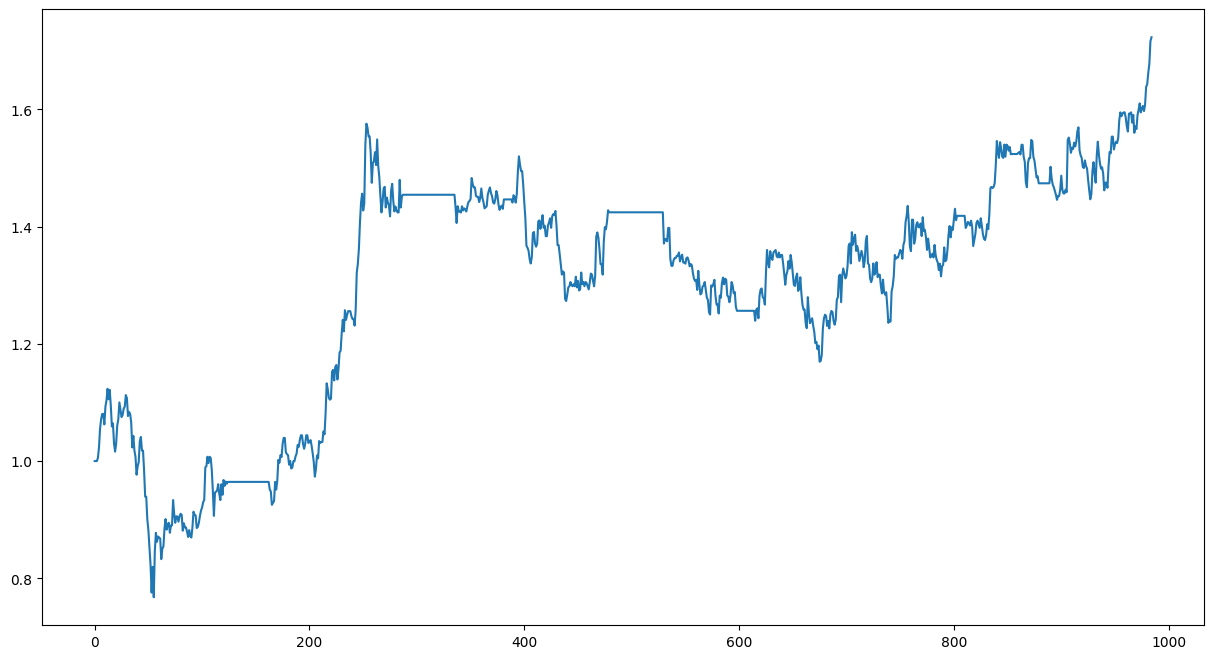

In [15]:
################ 백테스팅 파라미터 #############
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
daily_total_value = [] #일별 총 포트폴리오 가치
slippage = 0.0025 # 슬리피지 
################ 백테스팅 파라미터 #############

day, thres, _, _ = train_results.sort_values(by='return', ascending=False).iloc[0]

news_test_day = news_test.copy()
news_test_day['news_date'] = news_test_day.date.str.replace('.', '-').apply(lambda x:x[:10])
news_test_day = news_test_day[['news_date']+[f'prob_{day}' for day in days]].groupby('news_date').mean()

day = int(day)
day_news = -1
n_bid = 0

# 한 row 씩 루프
for idx, row in df_test.iterrows():

    daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
    
    prob = news_test_day.loc[news_test_day.index == row.name, f'prob_{day}'].values
    if len(prob) == 1:
        prob = prob[0]
    else:
        prob = 0
    
    
    # 매수: 전날 뉴스 기반 n일 후 상승 확률 예측값이 thres 이상인 경우
    if (position == 0) and (day_news == 1):
        # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
        position = int(holding_cash / row['close'])
        holding_cash -= position * row['close']
        avg_price = row['close']
        n_bid += 1
            
    # 매도: 최근 기사의 상승 확률 예측값이 thres 미만이고 최종 긍정 뉴스 발생에서 day일이 지난 경우
    elif (position > 0) and (day_news > day):
        holding_cash += (position * row['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
        position = 0
        avg_price = 0
        day_news = -1

    # 날짜 업데이트: n일 후 상승 확률 예측값이 thres 이상인 경우, 날짜 count reset
    if prob >= thres:
        day_news = 0
        
    if day_news > -1:
        day_news += 1

    daily_total_value[-1]+= holding_cash+ position* row['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산
    
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(daily_total_value/daily_total_value[0])

### (3) 전략 성과 측정

총 수익률: 72.28%
------------------------------------------------
총 백테스팅 기간: 3.94년
연 수익률: 14.80%
------------------------------------------------
일 수익률: 0.06%, 일 변동성: 0.01%
Sharpe ratio: 0.60
------------------------------------------------
MDD: -31.66%


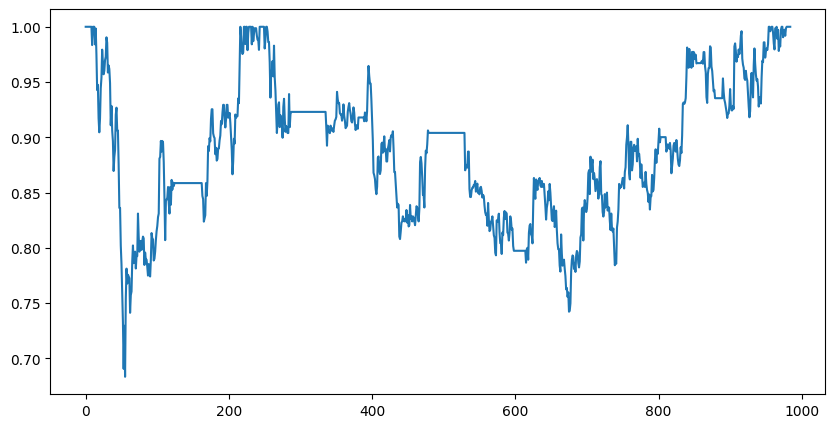

------------------------------------------------


In [16]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


### 4) 벤치마크와의 비교

총 수익률: 58.45%
------------------------------------------------
총 백테스팅 기간: 3.94년
연 수익률: 12.39%
------------------------------------------------
일 수익률: 0.05%, 일 변동성: 0.02%
Sharpe ratio: 0.46
------------------------------------------------
MDD: -40.14%


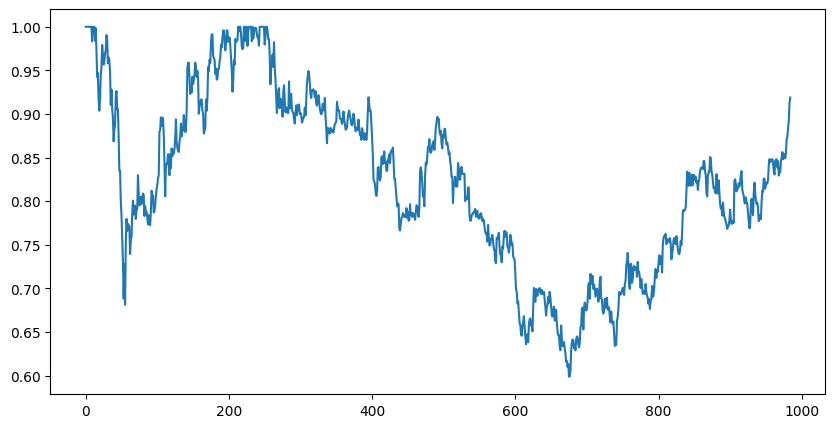

------------------------------------------------


In [17]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = df_test['close'].values/df_test['close'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')
